# Investigation of Bias in Judging Aspects of Professional Figure Skating

Data for this report was originally dowloaded from [Buzzfeed](https://github.com/BuzzFeedNews/2018-02-figure-skating-analysis) The cleaned data used here can be viewed at this link: https://drive.google.com/drive/folders/16Ad949NhaWhHYYfUKFPPiAsR68piFVJH

## Introduction

The data contains information on figure skating competitions, judges and skaters from 2016-2017. The data shows both element and component scores, judged technical and componenet aspects, and information on judges themselves. The purpose of this report is to investigate the judged aspects of figure skating competitions, so the performances.csv and judged-aspects.csv were used.  

There are four types of competition in professional figure skating:
- **Mens**
- **Ladies**
- **Pairs**
- **Ice Dancing**

The scoring for each type of competition differs according to the new [ISU Judging System](https://en.wikipedia.org/wiki/ISU_Judging_System). As such, this report will focus on the ladies competition, as it is the most popular and most likely to have some form of bias in the judgement. The total segment scores for figure skating is the sum of the technical and component sections of a performance, which is further discussed in the report below. 

The data for the performances and judged aspects are combined using SQL. This will provide a data frame that shows the technical elements and components of each skater during each competition they participated in. The SQL code is as follows:

**select** 
   
    *
   
**from**

    performances
    
**left join**
    
    judged_aspects
    
**on**
    
    performances.performance_id=judged_aspects.performance_id

## Analysis of the Judged Aspects of Professional Figure Skating

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
# import performance data and show the format
df_pj=pd.read_csv('performances_judged.csv')
df_pj.head()

,performance_id,competition,competition1,name,nation,rank,starting_number,total_segment_score,total_element_score,total_component_score,...,section,aspect_num,aspect_desc,info_flag,credit_flag,base_value,factor,goe,ref,scores_of_panel
0,b639d77459,ISU European Figure Skating Championships 2017,LADIES SHORT PROGRAM,Evgenia MEDVEDEVA,RUS,1,33,78.92,42.00,36.92,...,components,NaN,Transitions,NaN,NaN,NaN,0.8,NaN,NaN,9.07
1,9589bb2ebf,ISU GP Audi Cup of China 2016,ICE DANCE SHORT DANCE,Anastasia CANNUSCIO / Colin MCMANUS,USA,7,2,53.43,26.49,26.94,...,components,NaN,Transitions,NaN,NaN,NaN,0.8,NaN,NaN,6.64
2,71d2b1b597,ISU GP NHK Trophy 2016,MEN SHORT PROGRAM,Elladj BALDE,CAN,5,8,76.29,38.18,38.11,...,components,NaN,Performance,NaN,NaN,NaN,1.0,NaN,NaN,7.68
3,41a2345881,ISU European Figure Skating Championships 2017,ICE DANCE SHORT DANCE,Katerina BUNINA / German FROLOV,EST,29,8,39.47,20.68,19.79,...,components,NaN,Transitions,NaN,NaN,NaN,0.8,NaN,NaN,4.71
4,b017147b2f,ISU GP Audi Cup of China 2017,PAIRS FREE SKATING,Kirsten MOORE-TOWERS / Michael MARINARO,CAN,3,5,132.00,66.17,65.83,...,elements,1.0,3Tw2,NaN,NaN,5.8,NaN,-0.2,NaN,5.60


#### Clean the data and create data frames for the ladies competitions, split into elements and components

In [3]:
# lower the capilization of the program column to standardize formatting
df_pj['competition1'] = df_pj['competition1'].str.lower()

# find the rows that contain 'ladies' in the name of each program category in the data frame 
df_ladies=df_pj[df_pj['competition1'].str.contains('ladies' , regex=False, case=False, na=False)]

# lower and capitalize the last name of the lady skaters

# clean the text for interpretations
df_ladies['aspect_desc']=df_ladies['aspect_desc'].str.replace('Interpretation of the Music / Timing', 'Interpretation of the Music')
df_ladies['aspect_desc']=df_ladies['aspect_desc'].str.replace('Interpretation of the Music/Timing', 'Interpretation of the Music')

# create a data frame for the components of the ladies
df_compo=df_ladies[df_ladies['section'].str.contains('components', regex=False, case=False, na=False)]

# create a data frame for the elements of the ladies
df_elem=df_ladies[df_ladies['section'].str.contains('elements', regex=False, case=False, na=False)]

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


## What technical elements generally receive the highest scores?

The technical elements of figure skating competitions are organized into three categories:
- Jumps
- Spins
- Steps

More information for the codes for the different categories can be found in Appendix A at the end of the document. The element scores are calculated by awarding a grade of execution (GOE) factor for each element, which is then translated into a value using a scale of value (SOV), shown in Appendix B. The GOE values are then averaged using a 'trimmed mean' process, and finally the averaged value is added to the base value for the element. 

In order to simplify the technical elements data, the following code will organize each score by the above categories. This process will also make for easier data visualizations of the technical elements. 

In [4]:
# add an empty column for element_type
df_elem['element_type']=''

# populate the element_type column with the proper input
for x in df_elem.index:
    if 'Sp' in df_elem.aspect_desc.loc[x]:
        df_elem['element_type'].loc[x]=df_elem['element_type'].loc[x].replace('', 'spin')
    elif 'Sq' in df_elem.aspect_desc.loc[x]:
        df_elem['element_type'].loc[x]=df_elem['element_type'].loc[x].replace('', 'step')
    else:
        df_elem['element_type']=df_elem['element_type'].replace('', 'jump')  
        
# clean the errors for step
df_elem['element_type']=df_elem['element_type'].replace('stepjstepustepmsteppstep', 'step')

#clean the errors for spin
df_elem['element_type']=df_elem['element_type'].replace('spinjspinuspinmspinpspin', 'spin')

df_elem.head()

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.py

,performance_id,competition,competition1,name,nation,rank,starting_number,total_segment_score,total_element_score,total_component_score,...,aspect_num,aspect_desc,info_flag,credit_flag,base_value,factor,goe,ref,scores_of_panel,element_type
10,e37083608d,ISU GP 2016 Skate Canada International,ladies free skating,Joshi HELGESSON,SWE,10,1,100.05,47.14,52.91,...,10.0,2A,NaN,x,3.63,NaN,0.14,NaN,3.77,jump
14,055312da75,ISU GP Audi Cup of China 2016,ladies short program,Karen CHEN,USA,9,5,58.28,29.48,29.80,...,4.0,StSq3,NaN,NaN,3.30,NaN,0.50,NaN,3.80,step
15,4764e4873e,ISU European Figure Skating Championships 2017,ladies short program,Natasha MCKAY,GBR,24,6,45.97,24.77,21.20,...,7.0,FSSp4,NaN,NaN,3.00,NaN,0.21,NaN,3.21,spin
16,0ab242da08,ISU World Figure Skating Championships 2017,ladies short program,Elizabet TURSYNBAEVA,KAZ,10,31,65.48,36.65,28.83,...,6.0,FCSp4,NaN,NaN,3.20,NaN,0.07,NaN,3.27,spin
21,1b967c18c5,ISU European Figure Skating Championships 2017,ladies free skating,Joshi HELGESSON,SWE,13,8,98.93,46.87,52.06,...,4.0,FCCoSp4,NaN,NaN,3.50,NaN,0.07,NaN,3.57,spin


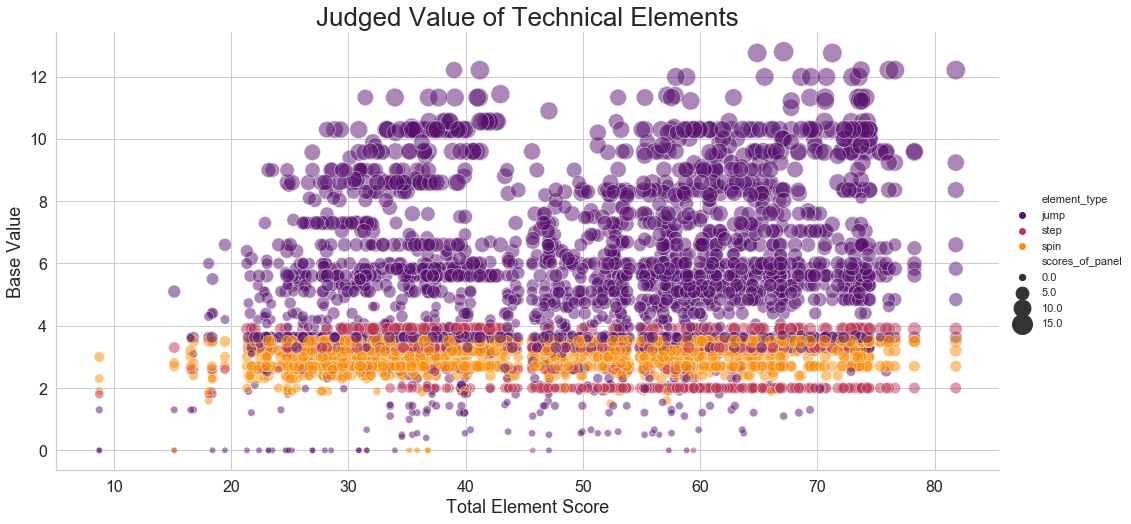

In [5]:
# create a relplot showing the type of elements in the dataset
sns.set(style='whitegrid')
sns.relplot(x="total_element_score", y="base_value", hue="element_type", size="scores_of_panel",
            sizes=(40, 400), alpha=.5, palette="inferno", height=7, aspect=2,
            data=df_elem)
plt.title('Judged Value of Technical Elements', fontsize=26)
plt.ylabel('Base Value', fontsize=18)
plt.xlabel('Total Element Score', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

In [6]:
df_elem['element_type'].value_counts()

jump    2368
spin    1451
step     702
Name: element_type, dtype: int64

Jumps tend to have a higher base value than other elements, tend to receive higher scores than other elements, and skaters in the dataset attempt many more jumps than other elements. The higher base value for the jumps element show that judges place much more importance on jumps than the other technical elements.  

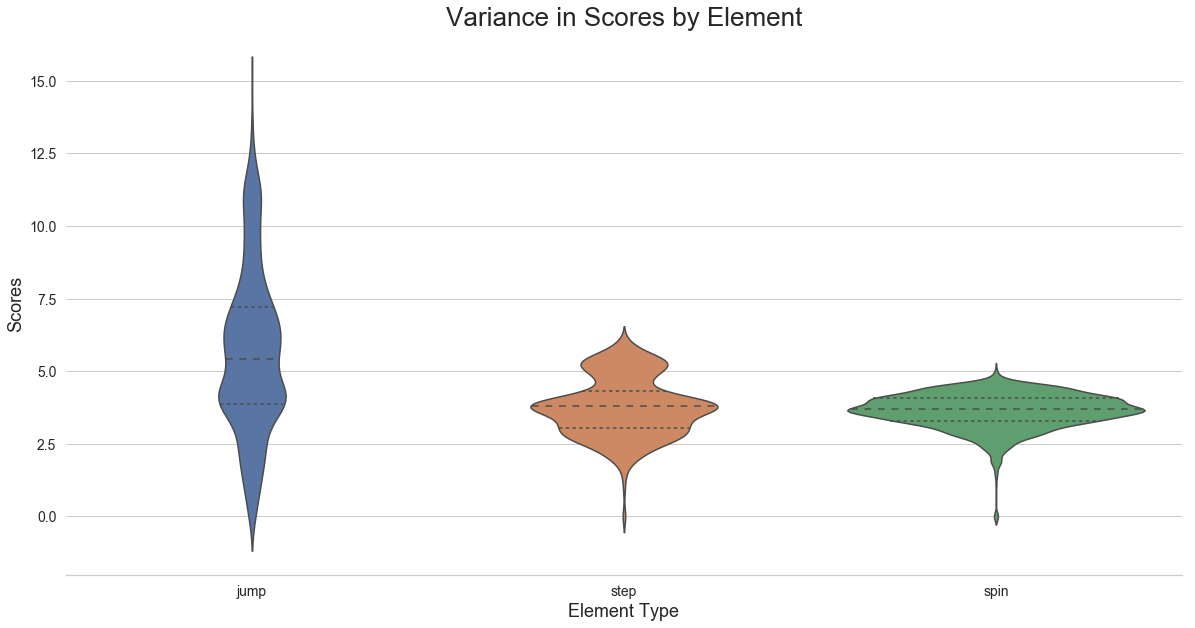

In [7]:
# plot the variance in scores by type of comoponent
plt.figure(figsize=(20, 10))
sns.violinplot(x="element_type", y="scores_of_panel",
               split=True, inner="quart",
               data=df_elem)
plt.xlabel('Element Type', fontsize=18)
plt.ylabel('Scores', fontsize=18)
plt.title('Variance in Scores by Element', fontsize=26)
plt.tick_params(axis='both', which='both', labelsize=14)
sns.despine(left=True)

Since jumps tend to make up the majority of the element score, the fact that this element also has the highest level of variance shows it is the most likely to be affected by judging bias, which then has a greater affect on the total element score.  

## What effect does the GOE have on element scores?

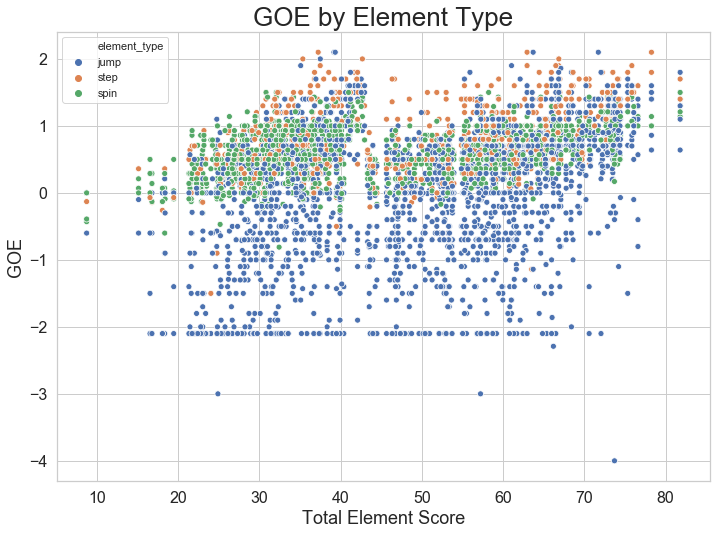

In [8]:
# create a scatter plot of GOE vs. total element score
sns.set(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="total_element_score", y="goe", hue='element_type', data=df_elem)
plt.title('GOE by Element Type', fontsize=26)
plt.ylabel('GOE', fontsize=18)
plt.xlabel('Total Element Score', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

Jumps tend to receive lower GOE's than the other elements, possibly because they are a more difficult maneuver. As the GOE is a judged factor that determines the final element score, the fact that jumps tend to receive lower GOEs further reinforces the hypothesis that jumps are the element most susceptible to bias. 

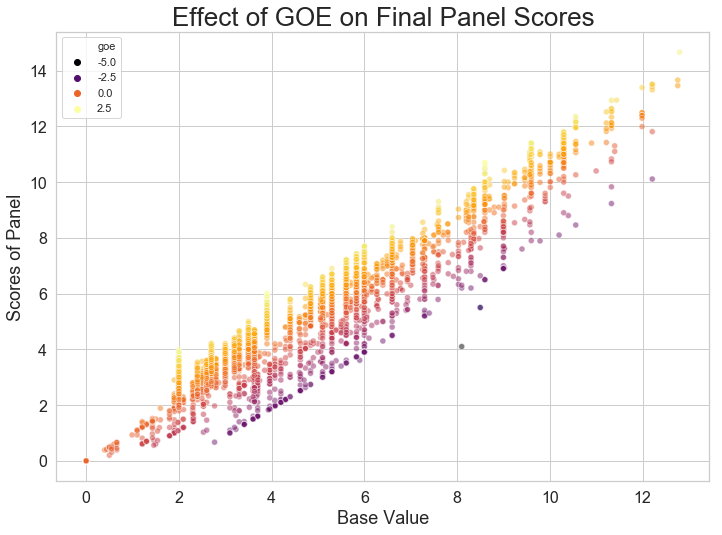

In [9]:
sns.set(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="base_value", y="scores_of_panel", hue="goe",
            alpha=.5, palette="inferno", data=df_elem)
plt.title('Effect of GOE on Final Panel Scores', fontsize=26)
plt.ylabel('Scores of Panel', fontsize=18)
plt.xlabel('Base Value', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

GOE has a large effect on the scores of the panel when viewed against the base value. Considering this fact, along with the high amount of lower GOE's for jumps and the element's popularity in competition, jumps are the element most susceptible to bias from the judges. 

## What components generally receive the highest scores?

Program Component Scores (PCS) are fall into five categories:
- Skating Skills
- Transitions
- Performance
- Composition
- Interpretation of the Music/Timing

Also, there is a component factor of 0.8 for the ladies short program and 1.6 for the ladies free skating program. The code below will add a program type category to show this factor.  

Component scores are not averaged nor dependent on the GOE, but components can be marked for deductions. How do the scores of these components compare to each other? 

In [10]:
# add an empty column for program_type
df_compo['program_type']=''

# populate the element_type column with the proper input
for x in df_compo.index:
    if df_compo.factor.loc[x]==1.6:
        df_compo['program_type'].loc[x]=df_compo['program_type'].loc[x].replace('', 'free_skate')
    elif df_compo.factor.loc[x]==0.8:
        df_compo['program_type'].loc[x]=df_compo['program_type'].loc[x].replace('', 'short_program')

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  i

In [11]:
df_compo.head()

,performance_id,competition,competition1,name,nation,rank,starting_number,total_segment_score,total_element_score,total_component_score,...,aspect_num,aspect_desc,info_flag,credit_flag,base_value,factor,goe,ref,scores_of_panel,program_type
0,b639d77459,ISU European Figure Skating Championships 2017,ladies short program,Evgenia MEDVEDEVA,RUS,1,33,78.92,42.00,36.92,...,NaN,Transitions,NaN,NaN,NaN,0.8,NaN,NaN,9.07,short_program
20,0ab242da08,ISU World Figure Skating Championships 2017,ladies short program,Elizabet TURSYNBAEVA,KAZ,10,31,65.48,36.65,28.83,...,NaN,Performance,NaN,NaN,NaN,0.8,NaN,NaN,7.29,short_program
33,d5614885a9,ISU Four Continents Championships 2017,ladies free skating,Wakaba HIGUCHI,JPN,9,13,113.22,57.55,55.67,...,NaN,Skating Skills,NaN,NaN,NaN,1.6,NaN,NaN,7.11,free_skate
44,38b004e4d1,ISU GP 2017 Bridgestone Skate America,ladies free skating,Bradie TENNELL,USA,3,6,137.09,72.68,64.41,...,NaN,Skating Skills,NaN,NaN,NaN,1.6,NaN,NaN,7.86,free_skate
48,8014019a5a,ISU GP NHK Trophy 2017,ladies short program,Carolina KOSTNER,ITA,2,8,74.57,37.25,37.32,...,NaN,Skating Skills,NaN,NaN,NaN,0.8,NaN,NaN,9.21,short_program


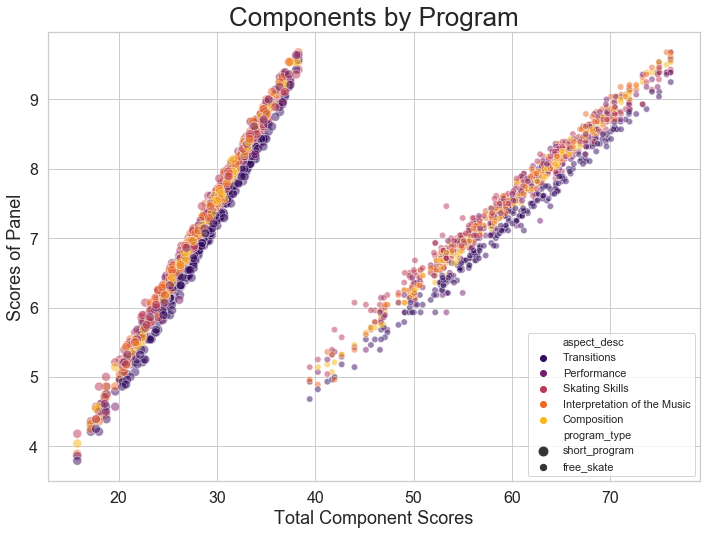

In [12]:
# create a scatter of total component scores vs. the scores of the panel by program type
sns.set(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="total_component_score", y="scores_of_panel", hue="aspect_desc", size='program_type',
            sizes=(40, 80), alpha=.5, palette="inferno", data=df_compo)
plt.title('Components by Program', fontsize=26)
plt.ylabel('Scores of Panel', fontsize=18)
plt.xlabel('Total Component Scores', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

Transisitions are the lowest awarded components for both programs, while skating skills and interpretation of the music/timing are the highest awarded components.

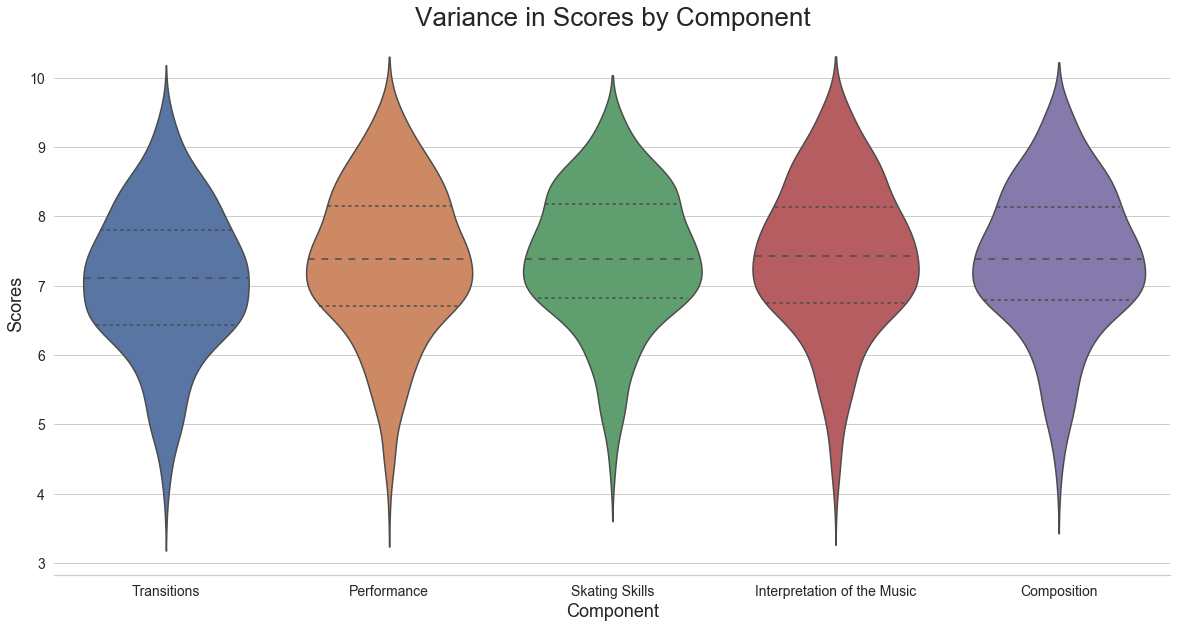

In [13]:
# plot the variance in scores by type of comoponent
plt.figure(figsize=(20, 10))
sns.violinplot(x="aspect_desc", y="scores_of_panel",
               split=True, inner="quart",
               data=df_compo)
plt.xlabel('Component', fontsize=18)
plt.ylabel('Scores', fontsize=18)
plt.title('Variance in Scores by Component', fontsize=26)
plt.tick_params(axis='both', which='both', labelsize=14)
sns.despine(left=True)

There is little variation across the component score by component type in the data set. The only possible outlier is transitions, which has a lower overall score than the other categories, but similar variance.  

## Which Judging Category Is the Majority of the Total Score?

In [14]:
# add an empty column for program_type
df_pj['program_type']=''

# populate the element_type column with the proper input
for x in df_pj.index:
    if df_pj.factor.loc[x]==1.6:
        df_pj['program_type'].loc[x]=df_pj['program_type'].loc[x].replace('', 'free_skate')
    elif df_pj.factor.loc[x]==0.8:
        df_pj['program_type'].loc[x]=df_pj['program_type'].loc[x].replace('', 'short_program')

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
df_pj.describe()

,rank,starting_number,total_segment_score,total_element_score,total_component_score,total_deductions,aspect_num,base_value,factor,goe,ref,scores_of_panel
count,23932.000000,23932.000000,23932.000000,23932.000000,23932.000000,23932.000000,15302.000000,15302.000000,8630.000000,15302.000000,0.0,23932.000000
mean,7.883169,7.929550,99.361830,50.394217,49.395199,0.427586,5.367207,4.917132,1.216686,0.434795,NaN,6.147335
std,6.525922,6.548071,37.110716,18.879934,18.907632,0.751289,3.216799,2.640675,0.433021,1.010606,NaN,2.536225
min,1.000000,1.000000,24.550000,8.750000,15.800000,0.000000,1.000000,0.000000,0.800000,-4.000000,NaN,0.000000
25%,3.000000,3.000000,68.250000,35.570000,32.650000,0.000000,3.000000,3.200000,0.800000,0.070000,NaN,4.070000
50%,6.000000,6.000000,93.480000,46.970000,46.420000,0.000000,5.000000,4.400000,1.000000,0.570000,NaN,6.300000
75%,10.000000,10.000000,126.510000,62.600000,64.410000,1.000000,7.000000,6.200000,1.600000,1.000000,NaN,7.860000
max,37.000000,37.000000,223.200000,126.120000,97.080000,9.000000,14.000000,17.900000,2.000000,3.300000,NaN,20.330000


In [17]:
# create a data frame with only free skate to show the makeup of the total segement score 
free=df_pj[(df_pj['program_type']=='free_skate')]
components=df_pj[(df_pj['program_type']=='')]
segments=free.append(components)

,performance_id,competition,competition1,name,nation,rank,starting_number,total_segment_score,total_element_score,total_component_score,...,aspect_num,aspect_desc,info_flag,credit_flag,base_value,factor,goe,ref,scores_of_panel,program_type
33,d5614885a9,ISU Four Continents Championships 2017,ladies free skating,Wakaba HIGUCHI,JPN,9,13,113.22,57.55,55.67,...,NaN,Skating Skills,NaN,NaN,NaN,1.6,NaN,NaN,7.11,free_skate
37,6ffb9688ae,ISU GP Trophee de France 2016,pairs free skating,Vanessa JAMES / Morgan CIPRES,FRA,2,2,132.53,67.91,64.62,...,NaN,Interpretation of the Music,NaN,NaN,NaN,1.6,NaN,NaN,8.14,free_skate
44,38b004e4d1,ISU GP 2017 Bridgestone Skate America,ladies free skating,Bradie TENNELL,USA,3,6,137.09,72.68,64.41,...,NaN,Skating Skills,NaN,NaN,NaN,1.6,NaN,NaN,7.86,free_skate
63,92a1f1cfc3,ISU GP Trophee de France 2016,pairs free skating,Natalia ZABIIAKO / Alexander ENBERT,RUS,4,4,121.20,59.42,62.78,...,NaN,Transitions,NaN,NaN,NaN,1.6,NaN,NaN,7.61,free_skate
95,1094fd9585,ISU GP 2016 Skate Canada International,pairs free skating,Liubov ILYUSHECHKINA / Dylan MOSCOVITCH,CAN,3,5,122.69,59.55,65.14,...,NaN,Composition,NaN,NaN,NaN,1.6,NaN,NaN,8.21,free_skate
116,c03efbc8c2,ISU European Figure Skating Championships 2017,ladies free skating,Anna POGORILAYA,RUS,3,24,137.00,67.75,69.25,...,NaN,Performance,NaN,NaN,NaN,1.6,NaN,NaN,8.68,free_skate
121,8f20120355,ISU GP 2017 Skate Canada International,ladies free skating,Marin HONDA,JPN,3,1,125.64,64.73,60.91,...,NaN,Interpretation of the Music,NaN,NaN,NaN,1.6,NaN,NaN,7.86,free_skate
141,9a6ba1ab79,ISU GP Rostelecom Cup 2017,ladies free skating,Wakaba HIGUCHI,JPN,3,10,137.57,69.37,68.20,...,NaN,Performance,NaN,NaN,NaN,1.6,NaN,NaN,8.61,free_skate
143,686cffa69c,ISU European Figure Skating Championships 2017,ladies free skating,Nathalie WEINZIERL,GER,17,4,94.70,47.61,49.09,...,NaN,Composition,NaN,NaN,NaN,1.6,NaN,NaN,6.25,free_skate
145,bcf029f2cf,ISU GP Audi Cup of China 2016,ladies free skating,Elizaveta TUKTAMYSHEVA,RUS,2,7,127.69,63.11,64.58,...,NaN,Transitions,NaN,NaN,NaN,1.6,NaN,NaN,7.68,free_skate


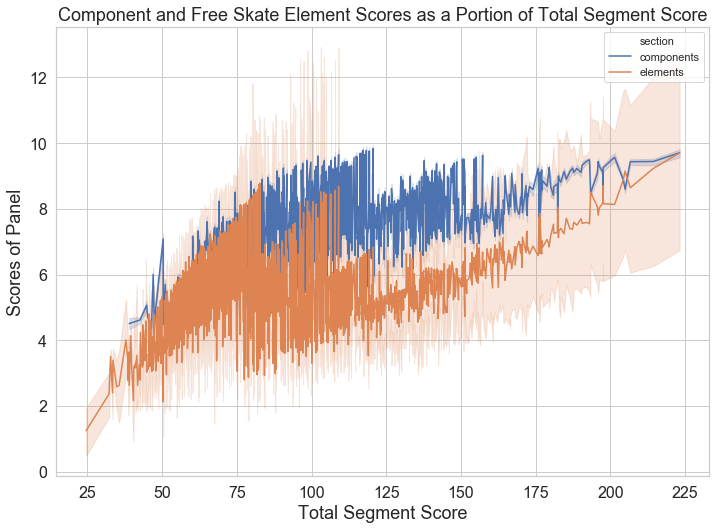

In [22]:
sns.set(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.lineplot(x='total_segment_score', y='scores_of_panel', data=segments,
                hue='section')
plt.title('Component and Free Skate Element Scores as a Portion of Total Segment Score', fontsize=18)
plt.ylabel('Scores of Panel', fontsize=18)
plt.xlabel('Total Segment Score', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

While component and element scores have similar means scores and standards of deviations, the chart above tells a different story. Components tend to receive higher panel scores, but element scores have much higher variation, especially as the segment score increases. 

This analysis shows that element scores have much higher variance across types than components. Therefore, the element with the highest variance in scores, jumps, is the variable of ladies professional figure skating chosen for experimental analysis.  

## Research Proposal 

Bias in the judging of professional figure skating can come on many forms. For example, Buzzfeed found [many judges will score skaters from their home countries higher than others](https://www.buzzfeednews.com/article/johntemplon/the-edge) in a form of national bias.

This report proposes that judges are also susceptible to *routine bias*, meaning judges can fall into patterns of judging based on their time in the ISU system. An example of routine bias would come from a judge who has been judging in the ISU for ten years. This judge will score a highly regarded skater higher than others because that judge has seen the skater compete over a long period and falls into a pattern of scoring him/her higher than others. However, this also means the same judge may score less regarded skaters (the majority of the judged population) lower than others, creating a system where judges susceptible to routine bias will judge the majority of professional skaters lower than the elite grouping.  

As the scores of the jump elements have the most variation in the score, combined with the fact that jumps make up the majority of the element score, the jump element is a good place to start looking for routine bias. In addition, the jump element score is dependent on the GOE factor, making it the judging aspect most open to bias. This research proposal will attempt to find routine bias in the jump elements of professional ladies figure skating.  

### Hypothesis

**ISU trainee judges will give higher jump scores than established judges becasue they lack *routine bias*.** 

### Rollout Plan

As the previous analysis shows, the jump elements of ladies professional figure skating are the most likely to be open to routine bias from judges. All element scores are based on the GOE factor, so this is the judging category of focus for the research proposal. 

For the 2019 competition year, data from all ladies professional figure skating competitions should be recorded in the format of the joined table 'df_pj' referenced in the analysis. After the year is complete, a random sample of performances will be taken from the overall 2019 data set, amounting to at least 20% of the total performances for 2019. All scoring information, names, country of origin, and other demographic information will then be removed from the sample dataset. 

A recording of the performances of the skaters in the random sampling will then be judged by a random panel of volunteers in the ISU judge training program (Appendix C), who will be unaware of the purpose of this experiment. All scoring information, names, country of origin, and other information will then be removed from the recording of each performance before being shown to the panel. The random panel will re-score the entirety of each perfomance, both components and elements, based on the same ISU judging rules as the original judges. These scores will be named 'test scores' for the purpose of this experiment, and the original judges' scores will be known as 'original scores.'  

### Evaluation Plan

Once both sets of scores are judged, an A/B test will then be run for the for the test and original scores, with a random sampling of 1,000 jump scores taken from both populations. 

**The first metric of success:** at least 5% of the test scores have a higher score than the original scores.    

**The second metric of success:** less than 1% of the test scores having a lower score than the original scores.     

### Follow Up 

If the hypothesis from the first year of testing proves correct (both success metrics are reached), the test should be run again each year for five more years. If the hypothesis from the first year of testing proves incorrect (both success metrics are not reached), then the test should be run again reach year for five more years, but with the hypothesis that ISU judges will give lower jump scores because of routine bias. If only one of the metrics shows any level of success, then the experimentation should stop after the first year and it should be assumed that there is no routine bias concerning the jump element of ladies professional figure skating.  

As this research proposal is testing for routine bias in the judgement of professional figure skating, many more tests will need to be run on an annual basis to see if this form of bias continues to appear over time. Routine bias is a temporal form of bias, i.e. the hypothesis proposes that this form of bias affects judges who have been judging for some amount of time. 

For further testing the sucess metrics will remain the same, but as these scores will be recorded, judges' tenure should be taken into consideration (after a baseline metric of success is established from the first year of analysis). The judges can then be split into a *tenured* and *non-tenured* category, in order to replace the trainee judges in the study.  

Additional proposals for futher testing include but are not limited to:
- Running the same analysis for judges with tenure greater than 10 years compared to those with tenure less than ten years
- Running the same analysis for other elements: steps and spins
- Running the same analysis for components
- Running the same analysis for different skating catgories such as free skate or pairs
- Running the same analysis for mens' and ladies' competitions

# Appendix

## Appendix A - Abbreviation of Elements

In [19]:
from IPython.display import IFrame
IFrame("http://www.isuresults.com/seminars/AbbreviationsElements_2014_15.pdf", width=900, height=800)

## Appendix B - Scale of Values

In [20]:
from IPython.display import IFrame
IFrame("http://www.usfsa.org/content/2018-19%20SP%20Scale%20of%20Values.pdf", width=900, height=800)

## Apendix C - Training Program for ISU Judges

In [21]:
from IPython.display import IFrame
IFrame("http://iceskatingresources.org/TrainingForJudges.html", width=900, height=800)